# Kernel Background Estimator

This notebook tutorial shows how to work with `KernelBackgroundEstimator`.

You can find the [docs here](http://docs.gammapy.org/en/latest/api/gammapy.detect.KernelBackgroundEstimator.html#gammapy.detect.KernelBackgroundEstimator)
and [source code on GitHub here](https://github.com/gammapy/gammapy/blob/master/gammapy/detect/kernel.py#L55) for better understanding how the algorithm is constructed. 

## Setup

On this section we just import some packages that can be used (or maybe not) in this tutorial. You can also see the versions of the packages in the outputs below and notice that this notebook was written on Python 2.7. Don't worry about that because the code is also Python 3 compatible.

In [1]:
# Render our plots inline
%pylab inline

import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
print ('Python version: ' + sys.version)
print ("Numpy version: " + np.__version__)
print ('Scipy version: ' + sp.__version__)

Python version: 2.7.12 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Numpy version: 1.11.0
Scipy version: 0.17.1


## Investigate the Estimator!

Let's start with importing the data.

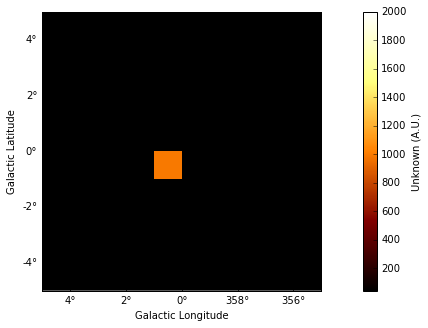

In [3]:
from gammapy.image import SkyImage

counts_image = SkyImage.empty(nxpix=10, nypix=10, binsz=1, fill=42)
counts_hdu = counts_image.to_image_hdu()
counts_hdu.data[4][4] = 1000
counts = counts_hdu.data

counts_image.plot(vmax=2000)

Сompose data as `Kernel Background Estimator Data`.

In [4]:
from gammapy.detect import KernelBackgroundEstimatorData

images = KernelBackgroundEstimatorData(counts=counts, header=counts_hdu.header)

We want to explore how `KernelBackgroundEstimator` works. Define parameters of the estimator. Because this is a demonstration, look through all the parameters.

In [5]:
SIGNIFICANCE_THRESHOLD = 4.  # threshold above which regions are excluded
MASK_DILATION_RADIUS = 1  # (deg) Amount by which mask is dilated with each iteration
DELETE_INTERMEDIATE_RESULTS = True  # Specify whether results of intermediate iterations should be deleted
SAVE_INTERMEDIATE_RESULTS = False  # Specify whether to save intermediate results as FITS files to disk
BASE_DIR = None  # Base of filenames if save_intermediate_results = True.

# CORRELATION_RADIUS = 0.1  # deg 
source_kernel = np.ones((1, 3))
background_kernel = np.ones((5, 3))

Now we can initialize the estimator and than start it.

In [6]:
from gammapy.detect import KernelBackgroundEstimator

kbe = KernelBackgroundEstimator(
    images=images, 
    source_kernel=source_kernel, 
    background_kernel=background_kernel,
    significance_threshold=SIGNIFICANCE_THRESHOLD, 
    mask_dilation_radius=MASK_DILATION_RADIUS, 
    delete_intermediate_results=DELETE_INTERMEDIATE_RESULTS, 
    save_intermediate_results=SAVE_INTERMEDIATE_RESULTS, 
    base_dir=BASE_DIR,
)

Start algorithm with `max_iterations = 3`.

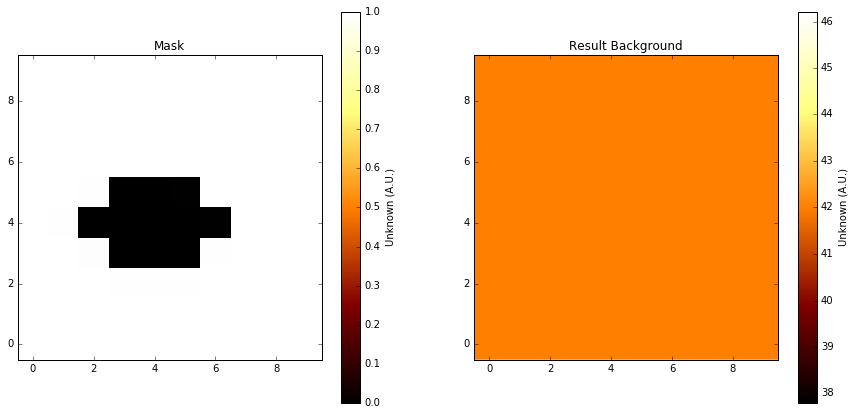

In [7]:
MAX_ITERATIONS = 3

mask, bkg = kbe.run(base_dir=BASE_DIR, max_iterations=MAX_ITERATIONS)
mask_image = SkyImage(data=mask)
bkg_image = SkyImage(data=bkg)

fig = plt.figure(figsize=(15, 7))

ax = plt.subplot(121)
mask_image.plot(vmax=1, ax=ax, fig=fig)
plt.title('Mask')

ax = plt.subplot(122)
bkg_image.plot(vmax=42, ax=ax, fig=fig)
plt.title('Result Background')

## Enother example

In [8]:
from scipy.ndimage import convolve
from astropy.units import Quantity
from gammapy.datasets import FermiGalacticCenter
from astropy.coordinates import Angle, SkyCoord

       
psf = FermiGalacticCenter.psf()
psf = psf.table_psf_in_energy_band(Quantity([10, 500], 'GeV'))
kernel_array = psf.kernel(pixel_size=Angle(1, 'deg'),
                          offset_max=Angle(3, 'deg'), normalize=True)

counts_blob = convolve(counts, kernel_array, mode='constant')

images_blob = KernelBackgroundEstimatorData(counts=counts_blob, header=counts_hdu.header)

In [9]:
SIGNIFICANCE_THRESHOLD = 4.  # threshold above which regions are excluded
MASK_DILATION_RADIUS = 1  # (deg) Amount by which mask is dilated with each iteration
DELETE_INTERMEDIATE_RESULTS = True  # Specify whether results of intermediate iterations should be deleted
SAVE_INTERMEDIATE_RESULTS = False  # Specify whether to save intermediate results as FITS files to disk
BASE_DIR = None  # Base of filenames if save_intermediate_results = True.

# CORRELATION_RADIUS = 0.1  # deg 
source_kernel = np.ones((1, 3))
background_kernel = np.ones((5, 3))

In [10]:
from gammapy.detect import KernelBackgroundEstimator

kbe_blob = KernelBackgroundEstimator(
    images=images_blob,
    source_kernel=source_kernel, 
    background_kernel=background_kernel,
    significance_threshold=SIGNIFICANCE_THRESHOLD, 
    mask_dilation_radius=MASK_DILATION_RADIUS, 
    delete_intermediate_results=DELETE_INTERMEDIATE_RESULTS, 
    save_intermediate_results=SAVE_INTERMEDIATE_RESULTS, 
    base_dir=BASE_DIR,
)

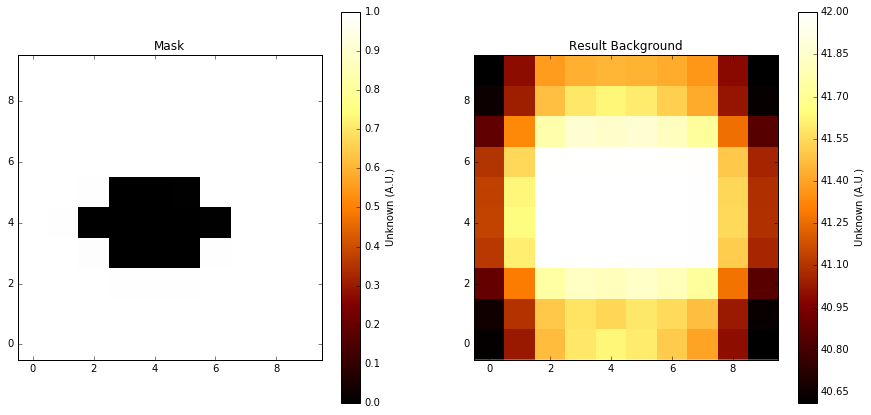

In [11]:
MAX_ITERATIONS = 3

mask_blob, bkg_blob = kbe_blob.run(base_dir=BASE_DIR, max_iterations=MAX_ITERATIONS)
mask_blob_image = SkyImage(data=mask_blob)
bkg_blob_image = SkyImage(data=bkg_blob)

fig = plt.figure(figsize=(15, 7))

ax = plt.subplot(121)
mask_blob_image.plot(vmax=1, ax=ax, fig=fig)
plt.title('Mask')

ax = plt.subplot(122)
bkg_blob_image.plot(vmax=42, ax=ax, fig=fig)
plt.title('Result Background')

## Enother example

In [12]:
import os
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from gammapy.image import SkyImage

filename = os.environ['GAMMAPY_EXTRA'] + '/datasets/fermi_survey/all.fits.gz'

image = SkyImage.read(filename=filename, extname='COUNTS')
background = SkyImage.read(filename=filename, extname='BACKGROUND')

size = Angle([10, 20], 'deg')
image = image.cutout(position=image.center, size=size)
background = background.cutout(position=background.center, size=size)

data = dict(image=image, background=background)

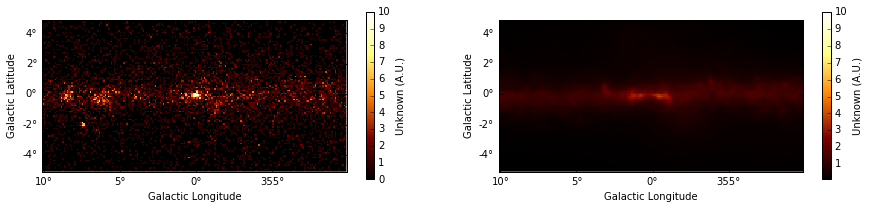

In [13]:
fig = plt.figure(figsize=(15, 3))

ax = fig.add_subplot(121, projection=data['image'].wcs)
data['image'].plot(vmax=10, ax=ax, fig=fig)

ax = fig.add_subplot(122, projection=data['background'].wcs)
data['background'].plot(vmax=10, ax=ax, fig=fig)

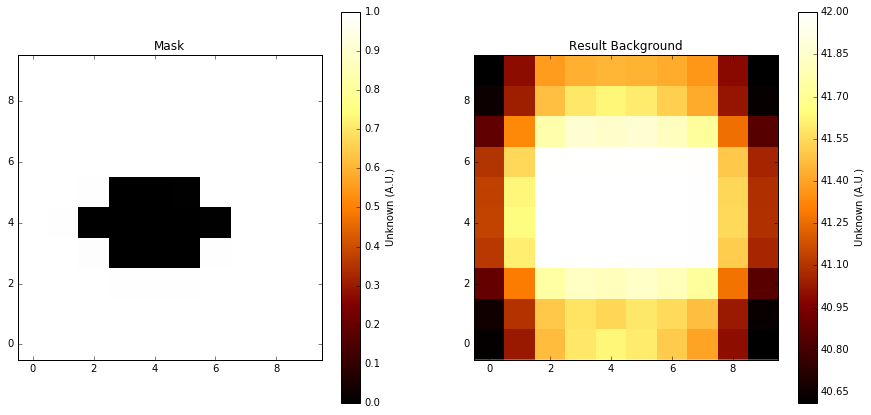

In [14]:
img_hdu = data['image'].to_image_hdu()

img_data = KernelBackgroundEstimatorData(counts=data['image'].data, header=img_hdu.header)

SIGNIFICANCE_THRESHOLD = 4.  # threshold above which regions are excluded
MASK_DILATION_RADIUS = 1  # (deg) Amount by which mask is dilated with each iteration
DELETE_INTERMEDIATE_RESULTS = True  # Specify whether results of intermediate iterations should be deleted
SAVE_INTERMEDIATE_RESULTS = False  # Specify whether to save intermediate results as FITS files to disk
BASE_DIR = None  # Base of filenames if save_intermediate_results = True.

# CORRELATION_RADIUS = 0.1  # deg 
source_kernel = np.ones((1, 3))
background_kernel = np.ones((5, 3))

from gammapy.detect import KernelBackgroundEstimator

kbe = KernelBackgroundEstimator(
    images=img_data,
    source_kernel=source_kernel, 
    background_kernel=background_kernel,
    significance_threshold=SIGNIFICANCE_THRESHOLD, 
    mask_dilation_radius=MASK_DILATION_RADIUS, 
    delete_intermediate_results=DELETE_INTERMEDIATE_RESULTS, 
    save_intermediate_results=SAVE_INTERMEDIATE_RESULTS, 
    base_dir=BASE_DIR,
)

MAX_ITERATIONS = 20

mask, bkg = kbe.run(base_dir=BASE_DIR, max_iterations=MAX_ITERATIONS)
mask_image = SkyImage(data=mask_blob)
bkg_image = SkyImage(data=bkg_blob)

fig = plt.figure(figsize=(15, 7))

ax = plt.subplot(121)
mask_image.plot(vmax=1, ax=ax, fig=fig)
plt.title('Mask')

ax = plt.subplot(122)
bkg_image.plot(vmax=42, ax=ax, fig=fig)
plt.title('Result Background')